In [1]:
import napari
import numpy as np
import matplotlib.pyplot as plt
import z5py
from pathlib import Path

from cryofib.n5_utils import read_volume, print_key_tree, write_volume
from cryofib.napari_utils import napari_add_group

## View n5 datasets

In [2]:
# postprocess_path = Path("/scratch/buglakova/data/cryofib/segm_fibsem/F059/F059_A1_em.n5/")
postprocess_path = Path("/g/kreshuk/buglakova/data/cryofib/segm_fibsem/F059/F059_A1_em.n5/")
f_em = z5py.File(postprocess_path, "r")

In [3]:
print_key_tree(f_em)

Key structure of z5 file /g/kreshuk/buglakova/data/cryofib/segm_fibsem/F059/F059_A1_em.n5
raw
segmentation
segmentation/nuclei


## Read volumes

In [4]:
# roi = np.s_[:, 400:600, :]
roi = np.s_[:, :, :]
em = read_volume(f_em, "raw", roi)


<class 'z5py.file.File'>
Reading roi (slice(None, None, None), slice(None, None, None), slice(None, None, None)) of volume raw from /g/kreshuk/buglakova/data/cryofib/segm_fibsem/F059/F059_A1_em.n5
Read volume with shape (1446, 1683, 1928), data type uint8


In [5]:
# f_em = "/scratch/buglakova/data/cryofib/segm_fibsem/F059/F059_A1_em_thin_boundaries_predictions.n5"
f_em = "/g/kreshuk/buglakova/data/tmp_view/F059_A1_em_thin_boundaries_predictions.n5"

In [6]:
# boundaries = read_volume(f_em, "dilated_boundary_predictions/dice_16x512x512/boundaries", roi)
# fg = read_volume(f_em, "dilated_boundary_predictions/dice_16x512x512/fg", roi)
extra = read_volume(f_em, "dilated_boundary_predictions/dice_16x512x512/extra", roi)

<class 'str'>
Reading roi (slice(None, None, None), slice(None, None, None), slice(None, None, None)) of volume dilated_boundary_predictions/dice_16x512x512/extra from /g/kreshuk/buglakova/data/tmp_view/F059_A1_em_thin_boundaries_predictions.n5
Read volume with shape (1446, 1683, 1928), data type float32


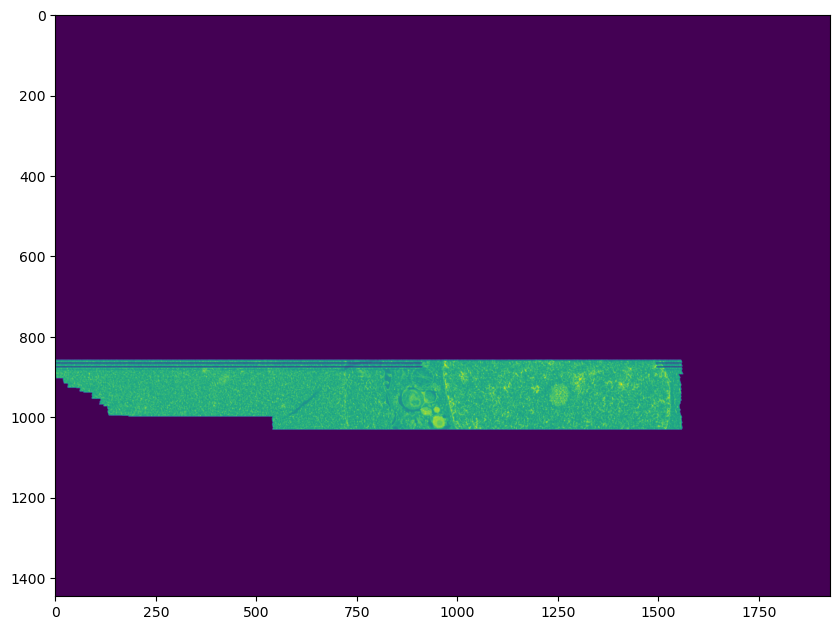

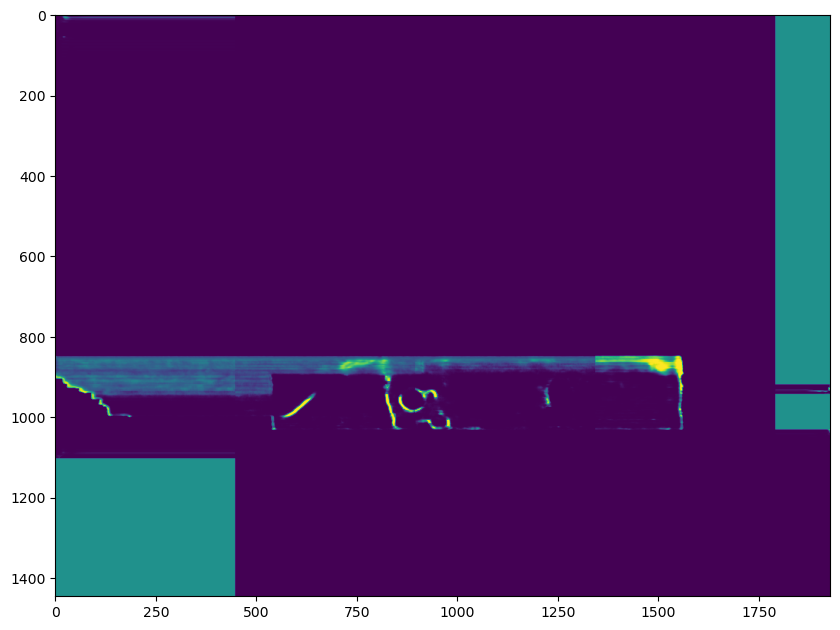

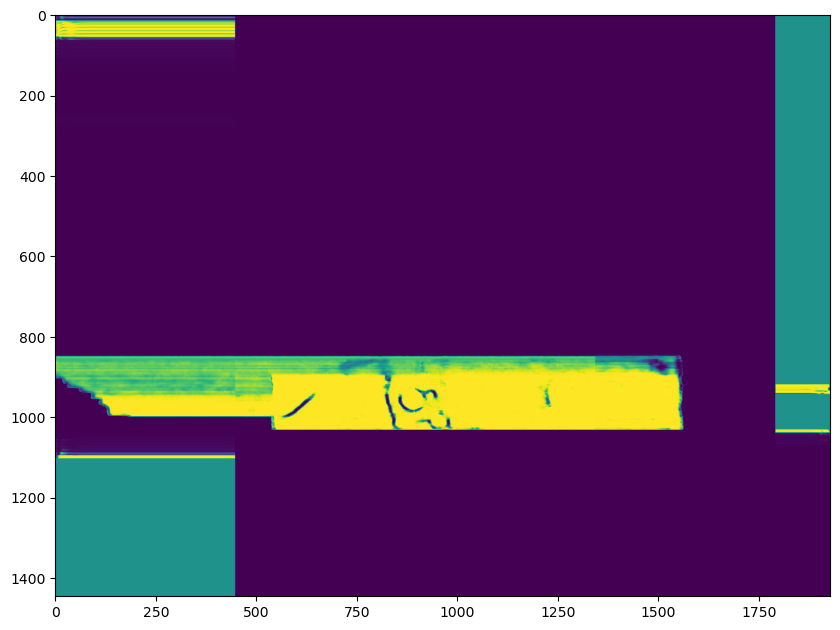

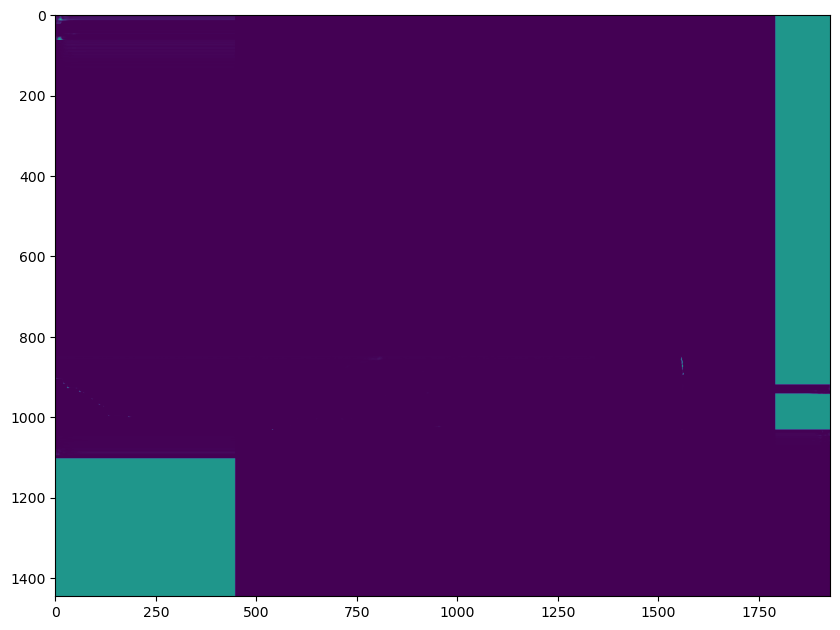

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(em[:, 30, :])
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(boundaries[:, 30, :])
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(fg[:, 30, :])
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(extra[:, 30, :])

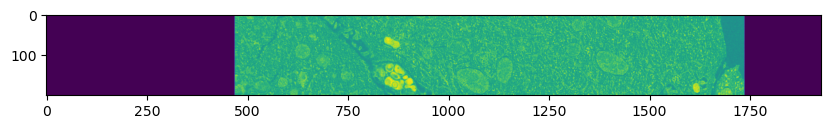

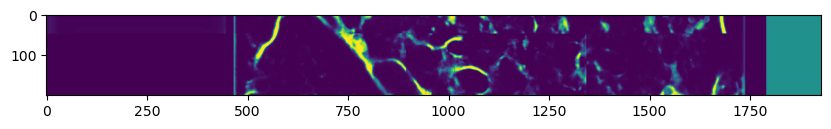

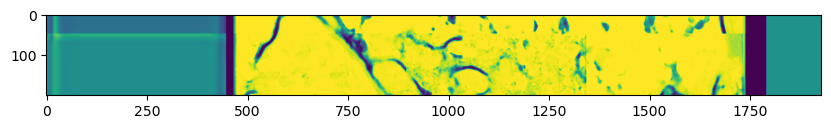

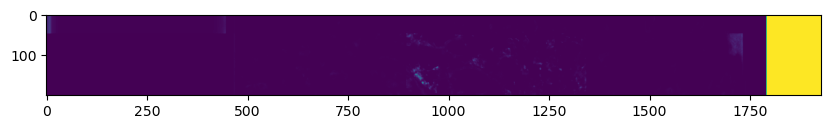

In [11]:
plt.figure(figsize=(10, 10))
plt.imshow(em[0, :, :])
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(boundaries[0, :, :])
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(fg[0, :, :])
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(extra[0, :, :])

## Open raw in napari

In [7]:
v = napari.Viewer()

In [8]:
v.add_image(em, name="raw")

<Image layer 'raw' at 0x7f13bc21e920>

In [9]:
v.add_image(boundaries, name="boundaries")

<Image layer 'boundaries' at 0x7f68c40fb370>

In [12]:
boundaries_bin = boundaries > 0.8

In [13]:
v.add_labels(boundaries_bin, name="boundaries")

<Labels layer 'boundaries' at 0x7f74340ce560>

In [10]:
v.add_image(extra, name="extra")

<Image layer 'extra [1]' at 0x7f13b467e830>

In [9]:
extra_bin = extra > 0.8
v.add_labels(extra_bin, name="extra")

<Labels layer 'extra' at 0x7f14e1443070>

In [16]:
for ch in range(segmentation.shape[0]):
    v.add_labels(segmentation[ch, ...], name=f"segmentation ch {ch}")

In [9]:
# napari_add_group(f_em, "channels", v)

### Prepare new training dataset

In [20]:
from skimage.measure import label

def get_zero_component(img: np.ndarray):
    bg = label(img == 0)
    component_sizes = [np.count_nonzero(bg == i) for i in np.unique(bg)[1:]]
    if len(component_sizes) == 0:
        return img > 0
    bg_ind = np.argmax(component_sizes) + 1
    bg = (bg == bg_ind)
    fg = (bg != bg_ind)
    return fg


def get_fg_mask(raw: np.ndarray):
    print("Compute foreground mask")
    print("Raw data shape: ", raw.shape)
    fg_mask = np.array([get_zero_component(img) for img in raw])
    return fg_mask

In [14]:
boundaries_corrected = v.layers["boundaries"].data

In [11]:
f_train = Path("/g/kreshuk/buglakova/data/tmp_view/F059_A1_em_train_network.n5")

In [12]:
extra_corrected = v.layers["extra"].data
write_volume(f_train, extra_corrected, "predictions/extra")

<class 'pathlib.PosixPath'>
Created dataset predictions/extra
Writing array to predictions/extra


In [18]:
write_volume(f_train, boundaries_corrected, "predictions/boundaries")

<class 'pathlib.PosixPath'>
Created dataset predictions/boundaries
Writing array to predictions/boundaries


In [24]:
fg = get_fg_mask(em).astype(np.uint16)

Compute foreground mask
Raw data shape:  (1446, 1683, 1928)


In [26]:
write_volume(f_train, fg, "predictions/fg")

<class 'pathlib.PosixPath'>
Overwriting predictions/fg
Writing array to predictions/fg


In [ ]:
write_volume(f_train, boundaries_corrected * fg, "predictions/boundaries")

<class 'pathlib.PosixPath'>
Overwriting predictions/boundaries
Writing array to predictions/boundaries


In [ ]:
write_volume(f_train, 1 - fg, "predictions/bg")